# LIBRARY PREPARATION

In [1]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# DATA PREPARATION

In [2]:
# 8:2 ratio
df = pd.read_csv('../Dataset/TSLA_data.csv') # Read data
df = df[['Close']]
df = df.dropna() # Drop NaN values
df = df.reset_index(drop=True) # Reset the index

In [3]:
print(df.dtypes)

Close    float64
dtype: object


# STATIONARY TEST USING AUGMENTED DICKEY-FULLER (ADF)

In [4]:
# ADF Test Function
def adf_test(series,title=''):
    """ Input a time series and an optional title to return an ADF report """

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF Test Statistic','p-value','# Lags used','# Observations']
    out = pd.Series(result[0:4],index = labels)

    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis,\nReject the null hypothesi,\n --> Data has no unit root and is STATIONARY")
    else:
        print("\nWeak evidence against the null hypothesis,\nFail to reject the null hypothesis,\n --> nData has a unit root and is NON-STATIONARY")
     

In [5]:
adf_test(df['Close'], 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic        -1.941846
p-value                    0.312639
# Lags used               24.000000
# Observations          1810.000000
Critical Value (1%)       -3.433968
Critical Value (5%)       -2.863138
Critical Value (10%)      -2.567621

Weak evidence against the null hypothesis,
Fail to reject the null hypothesis,
 --> nData has a unit root and is NON-STATIONARY


# CONVERT TO STATIONARY TIME SERIES

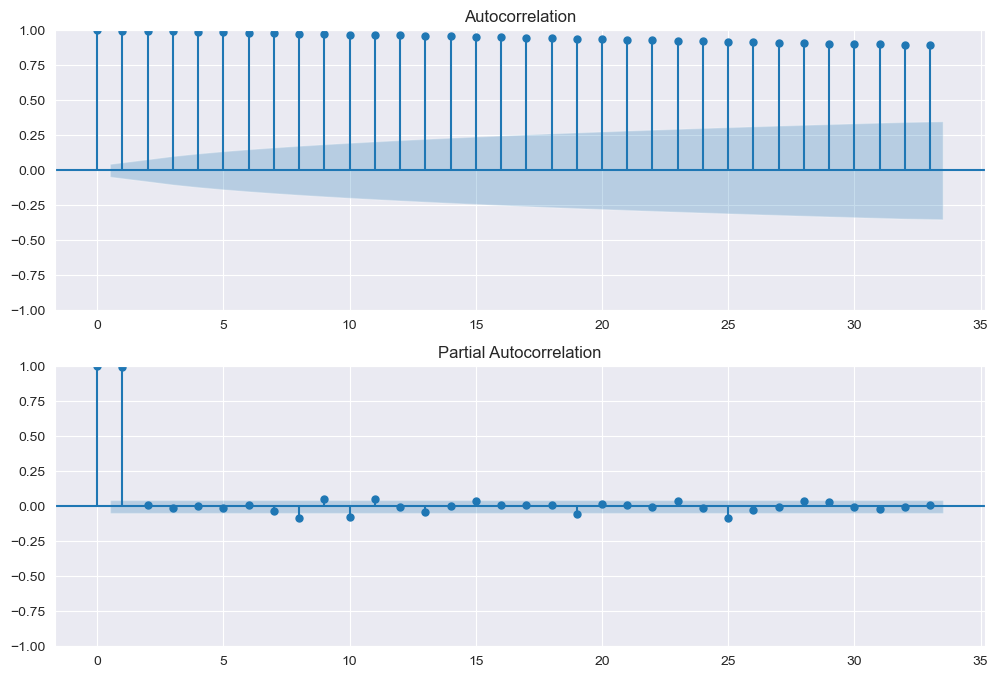

In [6]:
# Plotting the AutoCorrelation Function and Partial AutoCorrelation Function to determine ARIMA parameters.
fig, axes = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['Close'], ax=axes[0])
plot_pacf(df['Close'], ax=axes[1])
plt.show()

In [7]:
log_close = np.log(df['Close'])
log_diff = log_close.diff().dropna()

In [8]:
adf_test(log_diff, 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic       -43.611495
p-value                    0.000000
# Lags used                0.000000
# Observations          1833.000000
Critical Value (1%)       -3.433923
Critical Value (5%)       -2.863118
Critical Value (10%)      -2.567610

Strong evidence against the null hypothesis,
Reject the null hypothesi,
 --> Data has no unit root and is STATIONARY


# TRAIN-TEST SPLIT

In [9]:
# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# TRAINING PROCESSS

In [17]:
import numpy as np
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA tốt nhất bằng auto_arima
auto_model = auto_arima(y_train, start_p=1, start_q=1,
                        max_p=10, max_q=10, stationary=False,
                        start_P=0, seasonal=False,
                        d=1, D=1, trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=False)

# Lấy ra tham số tốt nhất (p,d,q)
best_order = auto_model.order

# Fit ARIMA model với order từ auto_arima
model = ARIMA(train_data['Close'], order=best_order)
model_fit = model.fit()

# Dự báo cho test_data
forecast = model_fit.forecast(steps=len(test_data))

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9882.286, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9882.791, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9884.380, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9886.380, Time=0.33 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=9881.565, Time=0.34 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=9881.121, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9882.739, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9883.617, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9885.560, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9887.040, Time=0.77 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=9882.029, Time=0.77 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9884.326, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9885.564, Time=0.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9886.121, Time=1.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9862.262, Time=1.61 sec
 ARIMA(3,1

In [18]:
### 1. Create sequence index
last_index =  df.index[-1]

# a) For 30 Days
last_data_30 = pd.RangeIndex(start = last_index, stop = last_index + 30, step = 1)

# b) For 60 Days
last_data_60 = pd.RangeIndex(start = last_index, stop = last_index + 60, step = 1)

# c) For 90 Days
last_data_90 = pd.RangeIndex(start = last_index, stop = last_index + 90, step = 1)


### 2. Create array

# a) Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

# b) Create an array of 60 consecutive integers starting from last_index
x_next_60_days = np.array(range(last_index + 1, last_index + 61)).reshape(-1, 1)

# c) Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index + 1, last_index + 91)).reshape(-1, 1)


### 3. Predict closing prices

# a) Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days))

# a) Predict the closing prices for the next 60 days
y_next_60_days = model_fit.forecast(steps=len(x_next_60_days))

# a) Predict the closing prices for the next 90 days
y_next_90_days = model_fit.forecast(steps=len(x_next_90_days))


### 4. Print result

# a) Print the predicted closing prices for the next 30 days
print('Predicted Closing Prices for the next 30 days:')
print(y_next_30_days)

# b) Print the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days[30:60])

# c) Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days[60:90])

Predicted Closing Prices for the next 30 days:
1468    200.563403
1469    201.849078
1470    200.259590
1471    200.969798
1472    201.525782
1473    200.310455
1474    201.183367
1475    201.247022
1476    200.437819
1477    201.278514
1478    201.034036
1479    200.592741
1480    201.287518
1481    200.892956
1482    200.741085
1483    201.242936
1484    200.816684
1485    200.863138
1486    201.172563
1487    200.791175
1488    200.950901
1489    201.097131
1490    200.800282
1491    201.004679
1492    201.029972
1493    200.829009
1494    201.029765
1495    200.977924
1496    200.865314
1497    201.033682
Name: predicted_mean, dtype: float64
Predicted closing prices for the next 60 days:
1498    200.942865
1499    200.900757
1500    201.024175
1501    200.923377
1502    200.930348
1503    201.007957
1504    200.916260
1505    200.951943
1506    200.990108
1507    200.917714
1508    200.965442
1509    200.973953
1510    200.924147
1511    200.972004
1512    200.961254
1513    200.93

# EVALUATION

In [19]:
# Calculate performance metrics
test_mae = mean_absolute_error(test_data, forecast)
test_mape = mean_absolute_percentage_error(test_data, forecast)
test_rmse = sqrt(mean_squared_error(test_data, forecast))
test_mse = mean_squared_error(test_data, forecast)

# Calculate Mean Absolute Scaled Error (MASE)
naive_forecast = train_data.shift(1).dropna()
mase_denom = mean_absolute_error(train_data[1:], naive_forecast)
test_mase = test_mae / mase_denom

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)
print('MSE:', test_mse)
print('MASE:', test_mase)

MAE: 61.10888540683941
RMSE: 88.88860367057141
MAPE: 0.20630238966253484
MSE: 7901.183862503921
MASE: 14.849000031050906


# VISUALIZATION

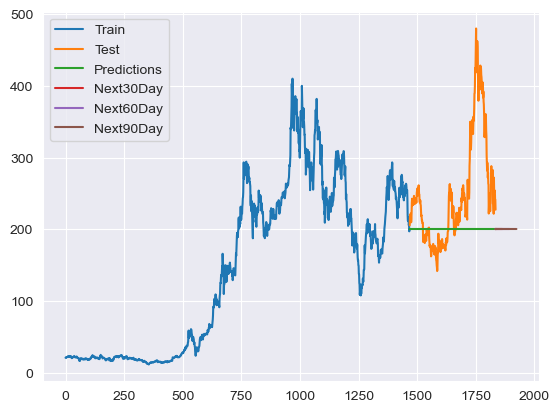

In [55]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, forecast)
plt.plot(last_data_30, y_next_30_days)
plt.plot(last_data_60, y_next_60_days)
plt.plot(last_data_90, y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

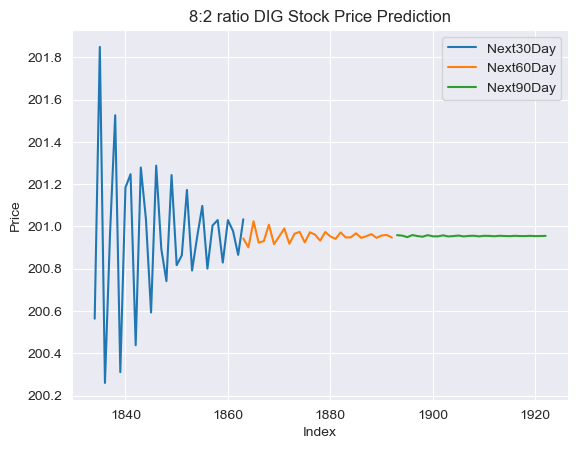

In [20]:
plt.plot(last_data_30, y_next_30_days)
plt.plot(range(last_data_30[-1], last_data_60[-1]), y_next_60_days[30:])
plt.plot(range(last_data_60[-1], last_data_90[-1]), y_next_90_days[60:])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('8:2 ratio DIG Stock Price Prediction')
plt.legend(['Next30Day', 'Next60Day', 'Next90Day'])

plt.show()